<div style="text-align:center"><span style="color:blue; font-family:Times New Roman; font-size:3em;"> Logistic regression modeling </span></div>

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;"> 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
In this section, the cervix images are classified by a simple logistic regression model. The file names of the training images are imported from the file 'df_cut_colorscaled.csv' which has been saved in the preprocessing step. The image features are extracted by different methods for all the training images. The output variables of the training data is loaded from 'y_train.pkl'. The performance of a logistic regression model is evaluated by applying grid search the best hyperparameters of the model in the 5-fold cross validation sets. 
 
 </span></div>

In [2]:
import glob
import mahotas as mh
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from pandas import DataFrame, Series
from mahotas.features import surf
from sklearn.cluster import KMeans
from mahotas.features import haralick
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from mahotas.features import lbp
from skimage.filters import sobel
from sklearn.decomposition import PCA
import cv2

In [3]:
df=pd.read_csv('df_cut_colorscaled.csv')
df.head()

,Class,ID,filename,label
0,Type_2,377,train_cut_colorscaled/Type_2\377.png,1
1,Type_2,243,train_cut_colorscaled/Type_2\243.png,1
2,Type_2,227,train_cut_colorscaled/Type_2\227.png,1
3,Type_2,574,train_cut_colorscaled/Type_2\574.png,1
4,Type_1,396,train_cut_colorscaled/Type_1\396.png,0


In [4]:
y_train=joblib.load('y_train.pkl', mmap_mode='c')

In [5]:
def gridsearch_LogisticRegression(x_train_features, y_train):
    parameters = {'penalty':('l1','l2'), 'C': np.logspace(-7,7,15)}
    classifier = LogisticRegression(random_state=0)
    grid = GridSearchCV(classifier,parameters, scoring='log_loss', n_jobs=-1,cv=5)
    grid.fit(x_train_features, y_train)
    print 'Best parameters set found on validation set:%r' % (grid.best_params_) 
    print 'Best average loss in validation set: %.5f' %(grid.best_score_)

<div style="text-align:left"><span style="color:red; font-family:Times New Roman; font-size:1.5em;">  
Haralick texture features 
</span></div>

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;"> 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
Haralick features are computed from a grey-level co-occurrence matrix. Each element of the matrix is the probability that a pixel with value i will be found adjacent to a pixel of value j. There are 14 statistics extracted the co-occurrence matrix for each direction of adjacency. Since there are four directions of adjacency, there are 52 texture features for each image. When Haralick features are applied into a logistic regression model, the best average Log loss in 5-fold cross validation is 0.92858. 


 
 </span></div>

In [48]:
feature_haralick=[]
for f in df['filename']:
    image=mh.imread(f,as_grey=True)
    h=haralick(image.astype('int32')).ravel()
    feature_haralick.append(h)

In [49]:
feature_haralick=np.vstack((feature_haralick))
feature_haralick.shape

(1409L, 52L)

In [50]:
gridsearch_LogisticRegression(feature_haralick, y_train)

Best parameters set found on validation set:{'penalty': 'l1', 'C': 1000.0}
Best average loss in validation set: -0.92858


<div style="text-align:left"><span style="color:red; font-family:Times New Roman; font-size:1.5em;">  
Surf 
</span></div>

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;"> 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
In SURF, descriptor vectors with length 64 each are constructed for each image. 
All of the descriptors extracted from the training images are grouped by K-means into N clusters. Each descriptor is categorized into its nearest cluster centroid. A histogram of length N is constructed by counting the number of descriptors placed into the i-th cluster.
A logistic regression model is used to classify each image using the histogram vector constructed by K-means. The best average Log loss in 5-fold cross validation is 0.97956 when N is 200.



 
 </span></div>

In [51]:
image_surf=[]
surf_feature_length=[]
for f in df['filename']:
    image=mh.imread(f,as_grey=True)
    s=surf.surf(image, 4, 6, 1, descriptor_only=True)
    surf_feature_length.append(np.shape(s)[0])
    image_surf.append(np.array(s))
image_surf_combined=np.concatenate(image_surf)

In [52]:
for n in [10, 20, 50, 100, 200, 300]:
    km=KMeans(n_clusters=n,init='k-means++',random_state=0)
    km.fit(image_surf_combined)

    feature_surf=[]
    start=0
    for i in surf_feature_length:
        end=start+i
        single_image=image_surf_combined[start:end,:]
        clusters=km.predict(single_image)
        features=np.bincount(clusters)
        features=np.append(features, np.zeros((1, n-len(features))))
        feature_surf.append(features)
        start=end
    print '#############################'
    print 'When the cluster number is %d :' %n    
    gridsearch_LogisticRegression(feature_surf, y_train)

#############################
When the cluster number is 10 :
Best parameters set found on validation set:{'penalty': 'l2', 'C': 100000.0}
Best average loss in validation set: -0.98416
#############################
When the cluster number is 20 :
Best parameters set found on validation set:{'penalty': 'l1', 'C': 0.01}
Best average loss in validation set: -0.99088
#############################
When the cluster number is 50 :
Best parameters set found on validation set:{'penalty': 'l2', 'C': 0.001}
Best average loss in validation set: -0.98246
#############################
When the cluster number is 100 :
Best parameters set found on validation set:{'penalty': 'l2', 'C': 0.001}
Best average loss in validation set: -0.98981
#############################
When the cluster number is 200 :
Best parameters set found on validation set:{'penalty': 'l2', 'C': 0.001}
Best average loss in validation set: -0.97956
#############################
When the cluster number is 300 :
Best parameters set fou

<div style="text-align:left"><span style="color:red; font-family:Times New Roman; font-size:1.5em;">  
Principal Component Analysis (PCA)
</span></div>

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;"> 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
PCA calculates Eigenvectors of a covariance matrix from the training set of images as principle features. These eigenvectors are ortho-normal (uncorrelated) to each other. PCA can reduce the number of features used to represent the data. When the principle features extracted from PCA are used as the inputs of a logistic regression model, the best average Log loss in 5-fold cross validation is 0.93210 


 
 </span></div>

In [6]:
feature_pca=[]
for f in df['filename']:
    image=mh.imread(f,as_grey=True)
    feature_pca.append(np.reshape(image,(256*256)))

In [7]:
x_train_feature_pca=np.vstack((feature_pca))  
pca = PCA(n_components=12, whiten=True,random_state=0).fit(x_train_feature_pca)
x_train_pca = pca.transform(x_train_feature_pca)
gridsearch_LogisticRegression(x_train_pca, y_train)

Best parameters set found on validation set:{'penalty': 'l1', 'C': 1.0}
Best average loss in validation set: -0.93210


<div style="text-align:left"><span style="color:red; font-family:Times New Roman; font-size:1.5em;">  
local directional pattern (LDP) 
</span></div>

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;"> 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
The LDP features are obtained by calculating different edge responses and generating a code for each pixel in an image. The resultant LDP-encoded values for all pixels are formed into a histogram as a single feature vector to efficiently represent the image. When a logistic regression model is combined with LDP descriptor, the best average Log loss in 5-fold cross validation is 0.94828. 

 
 </span></div>

In [8]:
feature_lbp=[]
for f in df['filename']:
    image=mh.imread(f,as_grey=True)
    p=lbp(image, radius=30, points=12)
    feature_lbp.append(p)
feature_lbp=np.vstack((feature_lbp))
feature_lbp.shape

(1409L, 352L)

In [9]:
gridsearch_LogisticRegression(feature_lbp, y_train)

Best parameters set found on validation set:{'penalty': 'l2', 'C': 9.9999999999999995e-08}
Best average loss in validation set: -0.94828


<div style="text-align:left"><span style="color:red; font-family:Times New Roman; font-size:1.5em;">  
Color histogram
</span></div>

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;"> 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
The 256 possible values of each color channel (R, G, B) in an image are mapped into a small set of values which are 0, 1, 2, 3, 4. The intensity value of a pixel is calculated by B + 5xG + 5x5xR. A histogram of an image is extracted from the intensity values of all pixel by calculating the number of pixels at a certain intensity value. Therefore, the 3D RGB color space is converted into 1-dimensional vector with 5x5x5 (125) features. The feature extraction from color histogram technique can achieve a log-loss value of 0.86822. 

 
 </span></div>

In [10]:
feature_colorhist=[]
for f in df['filename']:
    image=mh.imread(f)
    hist=cv2.calcHist([image], [0, 1, 2], None, [5, 5, 5], [0, 256, 0, 256, 0, 256])
    hist=hist.ravel() 
    feature_colorhist.append(np.log1p(hist))
feature_colorhist=np.vstack((feature_colorhist)) 
feature_colorhist.shape

(1409L, 125L)

In [11]:
gridsearch_LogisticRegression(feature_colorhist, y_train)

Best parameters set found on validation set:{'penalty': 'l1', 'C': 0.10000000000000001}
Best average loss in validation set: -0.86822


<div style="text-align:left"><span style="color:red; font-family:Times New Roman; font-size:1.5em;">  
Discussion 
</span></div>

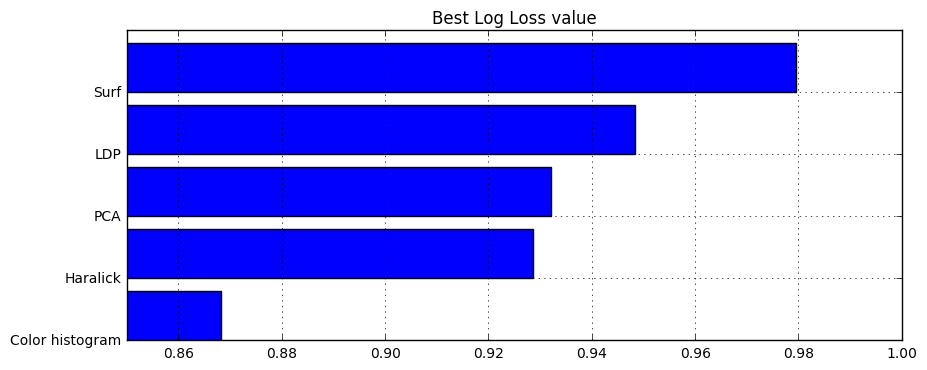

In [19]:
feature_extraction_methods=['Haralick', 'Surf', 'PCA', 'LDP', 'Color histogram' ]
log_loss=[0.92858, 0.97956, 0.93210, 0.94828, 0.86822]
methods_scores=zip(feature_extraction_methods, log_loss)
methods_scores=sorted(methods_scores, key=lambda x:x[1])

fig=plt.figure (figsize=(10,4), facecolor='white')
plt.barh(range(0, len(methods_scores)),zip(*methods_scores)[1])
plt.yticks(range(0, len(methods_scores)), zip(*methods_scores)[0])
plt.xlim([0.85,1.0])
plt.grid()
plt.title('Best Log Loss value')
plt.show()

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;"> 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
The calculated log-loss values for 5 different methods of image features extraction are shown above. As we can see, color histogram performs best among these feature extraction techniques. The features of color histogram can provides information about the characteristics of the intensity level distribution for an image. I am not a gynecologist, but I guess that the distinction of the cervix types is associated with the color contrast around the cervix. Cervix Type 1 tends to have obvious red appearance on the rest of pink color skin. Cervix Type 3 looks like only showing pink skin around the cervix. Type 2 is a mix between them. Color contrast plays a very important key to classify cervix types. Therefore, the color histogram technique can efficiently capture important features of the cervix images, compared with other methods. However, the log-loss score of 0.86 is not still satisfying. I will try a fantastic technique - convolutional neural network to improve the score in next section. 
 
 </span></div>